In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from tqdm import tqdm
from datetime import datetime
from heapq import heappush,heappop
from collections import Counter,defaultdict
import multiprocessing as mp
import tensorflow as tf
from sklearn.utils import shuffle
import time
from tensorflow.keras import Input,Model
from tensorflow.keras.layers import Embedding,Bidirectional,LSTM,Dense
from tensorflow.keras.losses import CategoricalCrossentropy 

In [2]:
PATHglove="/home/yui/Documents/data/nlp/glove.6B/glove.6B.50d.txt"
PATHner="/home/yui/Documents/data/nlp/ner/ner.txt"

In [3]:
class preprocess:
    def __init__(self,PATHglove,PATHner):
        self.PATHglove = PATHglove
        self.PATHner = PATHner
        self.initEmbeddings()
        self.V_ = len(self.w2id)
        self.k = len(self.res[0])
        self.getData()
        Lengths = list(map(len,self.sents))
        self.maxLength = max(Lengths)+1
        self.V = len(self.w2id)
        self.sents=[sent+[self.w2id["<e>"]]*(self.maxLength-len(sent)) 
                    for sent in self.sents]
        self.sents=[np.array(sent) for sent in self.sents]
        self.labels=[label+[0]*(self.maxLength-len(label)) 
                     for label in self.labels]
        self.labels=[np.array(label) for label in self.labels]
    def initEmbeddings(self):
        self.w2id,self.id2w,self.res={},{},[]
        with open(self.PATHglove) as f:
            lines = f.readlines()
            for i,line in enumerate(lines):
                line = line.strip()
                tokens = line.split(" ")
                word = tokens[0]
                vec = list(map(float,tokens[1:]))
                self.res.append(vec)
                self.w2id[word]=i
                self.id2w[i]=word
        print("[INFO] Loading Embeddings ... Done")
        print("Vocabulary size: ",len(self.w2id))
        print("Embeddings: ",self.res[0])
        print("----------")
    def getData(self):
        self.sents,self.labels,self.l2id,self.id2l = [],[],{},{}
        j = 0
        with open(self.PATHner) as f:
            lines = f.readlines()
            sent,slab = [],[]
            for i,line in enumerate(lines):
                line = line.strip()
                tokens = line.split("\t")
                word = tokens[0].lower()
                if word=="":
                    self.sents.append(sent)
                    self.labels.append(slab)
                    sent,slab = [],[]
                    continue
                label = tokens[1].lower()
                if word not in self.w2id:
                    i = len(self.w2id)
                    self.w2id[word]=i
                    self.id2w[i]=word
                if label not in self.l2id:
                    self.l2id[label]=j
                    self.id2l[j]=label
                    j+=1
                sent.append(self.w2id[word])
                slab.append(self.l2id[label])
        i=len(self.w2id)
        self.w2id["<e>"]=i
        self.id2w[i]="<e>"
        print("[INFO] Loading Data ... Done")
        print("Vocabulary size: ",len(self.w2id),
            len(self.id2w))
        print("Number of sentences: ",len(self.sents))
        print("Label size: ",len(self.l2id),len(self.id2l))
        print("----------")

In [4]:
pp = preprocess(PATHglove,PATHner)

[INFO] Loading Embeddings ... Done
Vocabulary size:  400000
Embeddings:  [0.418, 0.24968, -0.41242, 0.1217, 0.34527, -0.044457, -0.49688, -0.17862, -0.00066023, -0.6566, 0.27843, -0.14767, -0.55677, 0.14658, -0.0095095, 0.011658, 0.10204, -0.12792, -0.8443, -0.12181, -0.016801, -0.33279, -0.1552, -0.23131, -0.19181, -1.8823, -0.76746, 0.099051, -0.42125, -0.19526, 4.0071, -0.18594, -0.52287, -0.31681, 0.00059213, 0.0074449, 0.17778, -0.15897, 0.012041, -0.054223, -0.29871, -0.15749, -0.34758, -0.045637, -0.44251, 0.18785, 0.0027849, -0.18411, -0.11514, -0.78581]
----------
[INFO] Loading Data ... Done
Vocabulary size:  403139 403139
Number of sentences:  2394
Label size:  21 21
----------


In [5]:
class BiLSTM_NER:
    def __init__(self,pp,split=.9,batch_size=8,lr=1e-3):
        self.pp = pp
        self.split = split
        self.batch_size = batch_size
        self.lr = lr
        self.prepareData()
        self.prepareModel()
        self.cce=CategoricalCrossentropy(reduction=\
            tf.keras.losses.Reduction.SUM)
        self.opt=tf.keras.optimizers.Adam(learning_rate=lr)
    def prepareData(self):
        data=list(zip(pp.sents,pp.labels))
        random.shuffle(data)
        trainSet=data[:int(self.split*len(data))]
        testSet=data[int(self.split*len(data)):]
        self.trainX,self.trainY=list(zip(*trainSet))
        self.testX,self.testY=list(zip(*testSet))
        self.td = tf.data.Dataset.from_tensor_slices((\
                np.array(self.trainX),np.array(self.trainY)))
        self.td = self.td.shuffle(buffer_size=1024)\
                .batch(self.batch_size)
        self.vd = tf.data.Dataset.from_tensor_slices((\
                np.array(self.testX),np.array(self.testY)))
        self.vd = self.vd.batch(self.batch_size)
    def prepareModel(self):
        embed_matrix = np.random.randn(self.pp.V,self.pp.k)
        embed_matrix[:self.pp.V_,:]=np.array(self.pp.res)
        x = Input(shape=(self.pp.maxLength,))
        y = Embedding(self.pp.V,self.pp.k, 
            embeddings_initializer=tf.keras.initializers.Constant(\
            embed_matrix),trainable=True)(x)
        z = Bidirectional(LSTM(self.pp.k,
            return_sequences=True,dropout=0.2),merge_mode='concat')(y)
        z_ = Dense(len(self.pp.l2id), activation="softmax")(z)
        self.model = Model(inputs=[x],outputs=[z_])
    def train(self,epochs=500,printInterval=50):
        trainLosses,testLosses=[],[]
        lnum = len(self.pp.l2id)
        for epoch in range(epochs):
            total_train_loss=0
            for i,(x,y) in enumerate(self.td):
                with tf.GradientTape() as tape:
                    pred=self.model(x,training=True)
                    y = tf.one_hot(y,lnum)
                    loss = self.cce(y,pred)
                    total_train_loss+=loss.numpy()
                grads = tape.gradient(loss,
                        self.model.trainable_weights)
                self.opt.apply_gradients(zip(grads,
                        self.model.trainable_weights))

            if epoch%printInterval==0:
                total_val_loss=0
                for j,(x,y) in enumerate(self.vd):
                    pred=self.model(x,training=False)
                    y = tf.one_hot(y,lnum)
                    loss = self.cce(y,pred)
                    total_val_loss+=loss
                print("Epoch {} Train loss: {:.4f}".format(\
                        epoch,float(total_train_loss/(i+1))))
                print("Epoch {} Validation loss: {:.4f}".format(\
                        epoch,float(total_val_loss/(j+1))))
                trainLosses.append(total_train_loss/(i+1))
                testLosses.append(total_val_loss/(j+1))
        return trainLosses,testLosses

In [6]:
nerModel = BiLSTM_NER(pp,batch_size=1000)

In [7]:
epochs,printInterval=500,50
trainLosses,testLosses = nerModel.train(\
            epochs=epochs,printInterval=printInterval)

Epoch 0 Train loss: 83430.6432
Epoch 0 Validation loss: 22025.4453
Epoch 50 Train loss: 4292.4626
Epoch 50 Validation loss: 1761.0001
Epoch 100 Train loss: 3168.4464
Epoch 100 Validation loss: 1546.4680
Epoch 150 Train loss: 2146.9435
Epoch 150 Validation loss: 1446.1688
Epoch 200 Train loss: 1472.3177
Epoch 200 Validation loss: 1460.6355
Epoch 250 Train loss: 1009.6657
Epoch 250 Validation loss: 1529.0066
Epoch 300 Train loss: 704.2049
Epoch 300 Validation loss: 1611.2686
Epoch 350 Train loss: 483.3982
Epoch 350 Validation loss: 1710.8777
Epoch 400 Train loss: 347.9608
Epoch 400 Validation loss: 1796.9475
Epoch 450 Train loss: 243.8927
Epoch 450 Validation loss: 1862.5756


Text(0, 0.5, 'loss')

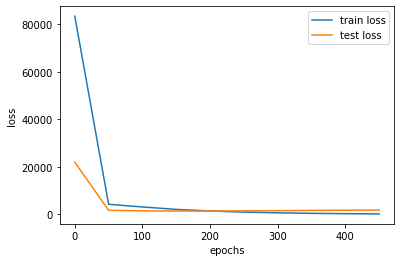

In [8]:
plt.plot(range(0,epochs,printInterval),
         trainLosses,label='train loss')
plt.plot(range(0,epochs,printInterval),
         testLosses,label='test loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')

In [9]:
show = 10
for i in range(show):
    x,y=nerModel.trainX[i],nerModel.trainY[i]
    ind = np.where(x==pp.w2id["<e>"])[0][0]
    pred = nerModel.model(x.reshape(1,-1),training=False)
    pred = tf.math.argmax(pred,2).numpy()[0][:ind]
    y = y[:ind]
    print(pred)
    print(y)

[0 0 0 0 0 0 0 0 0 6 0 0 0]
[0 0 0 0 0 0 0 0 0 6 0 0 0]
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
[0 0 5 0 0 0 0 0 0 0 0 0 0]
[0 0 5 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 14  0
  0]
[ 0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 14  0
  0]
[10  0  0  0  0  0 10 18  0 10  0  0 10  0  0  0  0  0]
[10  0  0  0  0  0 10 18  0 10  0  0 10  0  0  0  0  0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [10]:
def calculateMetrics(dataset,name):
    up,down=0,0
    TPs,FPs,FNs=dict(),dict(),dict()
    for i,(x,y) in enumerate(dataset):
        pred=nerModel.model(x,training=False)
        y = y.numpy()
        pred=tf.math.argmax(pred,2).numpy()
        for k in range(len(x)):
            ind = np.where(x[k]==pp.w2id["<e>"])[0][0]
            up+=(y[k][:ind]==pred[k][:ind]).sum()
            down+=np.prod(pred[k][:ind].shape)
            for e in range(ind):
                if pred[k][e]==y[k][e]:
                    TPs[y[k][e]]=TPs.get(y[k][e],0)+1
                elif pred[k][e]!=y[k][e]:
                    FPs[pred[k][e]]=FPs.get(pred[k][e],0)+1
                    FNs[y[k][e]]=FNs.get(y[k][e],0)+1
    print("{} accuracy: {:.2f}".format(name,up/down))
    for key in pp.id2l:
        f1 = TPs.get(key,0)/(TPs.get(key,0)+\
                FPs.get(key,0)*.5+FNs.get(key,0)*.5)
        print("Label {} F1 score : {:.2f}".format(pp.id2l[key],f1))

In [11]:
calculateMetrics(nerModel.td,"Training")
print("----------")
calculateMetrics(nerModel.vd,"Testing")

Training accuracy: 1.00
Label o F1 score : 1.00
Label b-facility F1 score : 0.98
Label i-facility F1 score : 0.98
Label b-other F1 score : 0.98
Label i-other F1 score : 0.99
Label b-company F1 score : 0.98
Label b-person F1 score : 1.00
Label b-tvshow F1 score : 0.97
Label b-sportsteam F1 score : 0.97
Label i-person F1 score : 1.00
Label b-geo-loc F1 score : 0.99
Label b-movie F1 score : 0.98
Label i-movie F1 score : 0.97
Label i-tvshow F1 score : 0.96
Label b-product F1 score : 0.98
Label i-company F1 score : 0.97
Label b-musicartist F1 score : 0.98
Label i-musicartist F1 score : 0.97
Label i-geo-loc F1 score : 0.99
Label i-product F1 score : 0.99
Label i-sportsteam F1 score : 0.97
----------
Testing accuracy: 0.95
Label o F1 score : 0.97
Label b-facility F1 score : 0.25
Label i-facility F1 score : 0.24
Label b-other F1 score : 0.45
Label i-other F1 score : 0.45
Label b-company F1 score : 0.54
Label b-person F1 score : 0.36
Label b-tvshow F1 score : 0.00
Label b-sportsteam F1 score : 

#### Notes
- It could be more useful to calculate F1 score for each class.